# Set up
Run the cell below before running the rest of the cells.

In [1]:
from collections import OrderedDict

import torch
import torch.nn as nn
torch.manual_seed(2109)

from matplotlib.ticker import LogLocator, FormatStrFormatter
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

# Question C.2: Backpropagation
We provide the neural network architecture in PyTorch code below, as well as the loss function. Check your answers to Question C.2 by replacing `raise NotImplementedError()` in `solution` with your answer.

Note that the matrix dimensions are flipped in PyTorch, where the first dimension is the number of training samples. This is just a difference in conventions, and will not affect much. Also note that we don't have the bias term in `X`, this is because the `nn.Linear` layer has it own bias included, and it will not affect your answers, since we are only asking for weight gradients.

In [2]:
'''
Define the inputs and outputs, the network, and the loss function
'''
n = 16  # Number of training samples
m_0 = 8  # Number of features for each training sample

X = torch.randn((n, m_0)) # random tensor of shape (n, m_0). Each row in X represents one training sample with m_0 features.
Y = torch.randint(0, 2, (n, 1), dtype=torch.float32) # random tensor of shape (n, 1). It represents the target labels (0 or 1) for n samples.

neural_net = nn.Sequential(OrderedDict([
    ('lin1', nn.Linear(m_0, 1)), # First layer is a linear layer with m_0 input features and 1 output feature. Perform initial transformation of input features into a single value.
    ('lin2', nn.Linear(1, 1)),  # Dummy layer so that we can illustrate part (c). It doesn't contribute anything.
    ('sig', nn.Sigmoid()) # Applies sigmoid activation function to output a value between 0 and 1.
]))

# Set dummy layer's weight to 1 to prevent it from affecting the first layer's gradients.
with torch.no_grad():
    neural_net.lin2.weight[0, 0] = 1

loss = nn.BCELoss() # In this question, we use binary cross entropy loss for our training.

In [3]:
'''
Obtain per-sample gradients for our dummy layer, divided by the output of `lin1`, to get the
derivative of loss w.r.t. f.

Not a common operation, but needed to illustrate Question 2 of the tutorial.

See https://pytorch.org/functorch/stable/notebooks/per_sample_grads.html for more details
about per-sample gradients and how to implement an optimized version of calculating them
using functorch, if you're interested.
'''
per_sample_gradients = torch.zeros((n, 1)) # Initializes a tensor of zeros with shape (n, 1) to store per-sample gradients of the loss w.r.t dummy layer's weight
lin1_output = torch.zeros((n, 1)) # Initialize a tensor of zeros with shape (n, 1) to store the output of the first linear layer for each training sample

neural_net = neural_net.to(device)
X, Y = X.to(device), Y.to(device)

for i in range(n):
    y_hat = neural_net(X[i]) # Computes forward pass through the neural network by passing the i-th sample.
    per_sample_gradients[i] = torch.autograd.grad(loss(y_hat, Y[i]), neural_net.lin2.weight)[0] # Calculates the gradient of the loss w.r.t dummy layer's weight for the i-th sample's contribution to loss
    lin1_output[i] = neural_net.lin1(X[i]) # Calculate the output for the first linear layer

dLoss_df = 1 / n * per_sample_gradients / lin1_output # Calculate the derivative of the loss w.r.t output of the first linear layer

In [4]:
'''
Predict Y using our network, and calculate the loss of our prediction.

Note that the gradients will automatically be calculated by PyTorch once you invoke the loss(...).backward() function.
'''
neural_net.zero_grad() # Initializes the gradients of all parameters to zero

Y_hat = neural_net(X) # Make prediction Y_hat for input data X

loss(Y_hat, Y).backward() # Compute the loss between predicted values Y_hat and actual target value Y, then invoke .backward() for performing back propagation

In [8]:
def solution(Y: torch.Tensor, Y_hat: torch.Tensor) -> torch.Tensor:
    return (Y_hat - Y) / Y.size(0)

assert torch.allclose(solution(Y, Y_hat), dLoss_df)

# Question D.1: Gradient Flow in Deep Neural Networks
Examine the code below and answer Question D.1.

In [22]:
'''
Create our 50-layer model.
'''

layer_dict = OrderedDict()
for i in range(50):
    layer_dict['lin{}'.format(i+1)] = nn.Linear(10, 10 if i < 49 else 5)
    layer_dict['act{}'.format(i+1)] = nn.LeakyReLU(negative_slope=0.01)

deep_neural_net = nn.Sequential(layer_dict)

deep_X = torch.randn(50, 10)
deep_Y = torch.randn(50, 5)

deep_Y_hat = deep_neural_net(deep_X)

deep_loss = nn.L1Loss()
deep_loss(deep_Y_hat, deep_Y).backward()

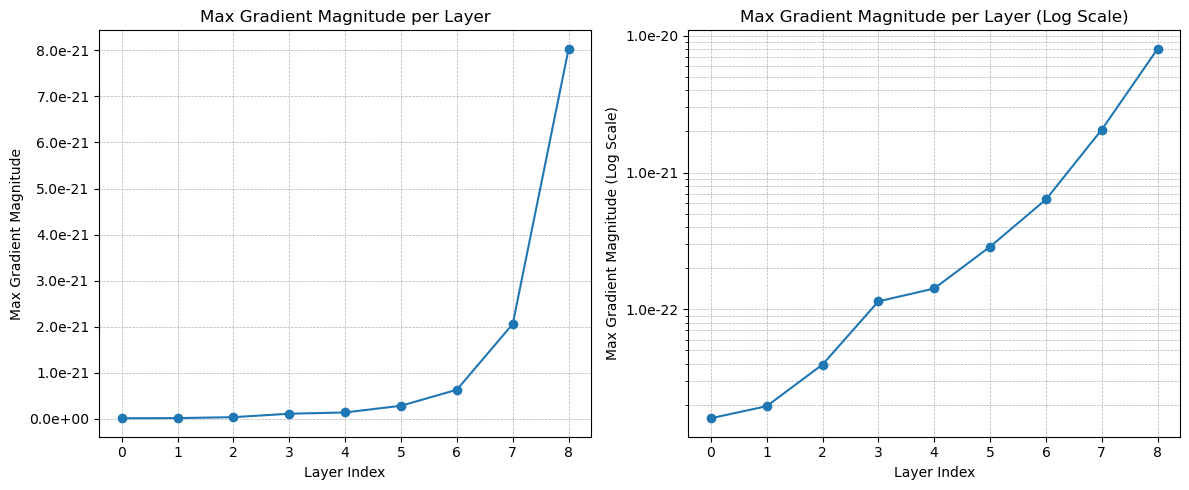

In [23]:
'''
Visualise the max gradient magnitude for the first 10 layers. Note the y-axis scale for
each plot you generate.

Feel free to play around with the method of visualisation here, e.g., change `display_layers`.
'''
display_layers = 10

# Collect max gradient magnitudes per layer
max_grad_magnitude_per_layer = []
for name, layer in deep_neural_net.named_modules():
    if isinstance(layer, nn.Linear) and int(name[3:]) < display_layers:
        max_grad_magnitude_per_layer.append(torch.max(torch.abs(layer.weight.grad)).item())

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Normal scale plot
axes[0].plot(max_grad_magnitude_per_layer, marker='o', linestyle='-')
axes[0].set_xlabel("Layer Index")
axes[0].set_ylabel("Max Gradient Magnitude")
axes[0].set_title("Max Gradient Magnitude per Layer")
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.1e'))

# Log scale plot
axes[1].plot(max_grad_magnitude_per_layer, marker='o', linestyle='-')
axes[1].set_xlabel("Layer Index")
axes[1].set_ylabel("Max Gradient Magnitude (Log Scale)")
axes[1].set_yscale('log')  # Set log scale

# Improve tick formatting for log scale
axes[1].yaxis.set_major_locator(LogLocator(base=10.0))
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
axes[1].set_title("Max Gradient Magnitude per Layer (Log Scale)")

# Add grids for better visualisation
for ax in axes:
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plots
plt.tight_layout()
plt.show()